In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datetime import datetime

from tqdm import tqdm
import json

In [2]:
from code import model
from code.data import Dataset
from code import epoch
from code import evaluation

In [3]:
root = os.getcwd()
batch = 8
forecast = 30
samples = 5
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = "cpu"

datetime = datetime.strftime(datetime.now(), "%Y-%m-%d_%H-%M")

# Model

In [4]:
dataset = Dataset(path=os.path.join(root, "training.csv"))

In [5]:
encoder = model.Extractor(in_channels=1, out_channels=1)
decoder = model.Decoder(classes=forecast) # forcast 30 days


predictor = model.Model(encoder=encoder, decoder=decoder).to(device)
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)

In [6]:
trainloader = DataLoader(dataset, batch_size=batch, shuffle=False, num_workers=2)

In [ ]:
train_info = {
       "kendal": []
}

for e in range(5000):
    
    kendal_max = -1
    
    train_loss = epoch.train_epoch(predictor, optimizer, trainloader, device)
    pr, gt = epoch.test_epoch(predictor, dataset, device)
    
    kendal = evaluation.kendal_tau_distance(gt, pr)
    train_info["kendal"].append(kendal)
    
    print("Epoch: {}, loss = {:.5f}, kendal = {:.5f}".format(e+1, train_loss, kendal))
    
    if kendal > kendal_max:
        checkpoint = {
            'model_stat': predictor.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }

        torch.save(checkpoint, os.path.join(root,
                                            "code",
                                            "{}.pth".format(datetime)))
        kendal_max = kendal
    with open(os.path.join(root, "code", "{}.json".format(datetime)), 'w') as f:
        json.dump(train_info, f)

145it [00:10, 13.39it/s]
1158it [00:18, 62.71it/s]


Epoch: 1, loss = 3.48939, kendal = 0.46964


145it [00:10, 13.72it/s]
1158it [00:18, 62.78it/s]

Epoch: 2, loss = 3.48385, kendal = 0.46081



145it [00:10, 13.57it/s]
1158it [00:18, 62.30it/s]


Epoch: 3, loss = 3.48164, kendal = 0.39424


145it [00:10, 13.47it/s]
1158it [00:18, 62.69it/s]

Epoch: 4, loss = 3.47754, kendal = 0.50718



145it [00:10, 13.41it/s]
1158it [00:18, 62.65it/s]

Epoch: 5, loss = 3.47704, kendal = 0.43875



145it [00:10, 13.54it/s]
1158it [00:18, 62.34it/s]

Epoch: 6, loss = 3.47677, kendal = 0.52175



145it [00:10, 13.69it/s]
1158it [00:18, 62.62it/s]


Epoch: 7, loss = 3.47467, kendal = -0.57239


145it [00:10, 13.34it/s]
1158it [00:18, 63.36it/s]

Epoch: 8, loss = 3.47288, kendal = -0.02431



145it [00:10, 13.24it/s]
1158it [00:18, 63.15it/s]

Epoch: 9, loss = 3.47300, kendal = 0.17883



145it [00:10, 13.44it/s]
1158it [00:18, 63.10it/s]

Epoch: 10, loss = 3.47145, kendal = -0.37180



145it [00:10, 13.82it/s]
1158it [00:18, 62.71it/s]

Epoch: 11, loss = 3.47185, kendal = 0.44858



145it [00:10, 13.73it/s]
1158it [00:18, 62.91it/s]


Epoch: 12, loss = 3.47024, kendal = 0.45341


145it [00:10, 13.24it/s]
1158it [00:18, 62.58it/s]

Epoch: 13, loss = 3.46974, kendal = 0.26701



145it [00:10, 14.17it/s]
1158it [00:18, 62.92it/s]

Epoch: 14, loss = 3.46892, kendal = 0.49815



145it [00:10, 13.72it/s]
1158it [00:18, 62.69it/s]

Epoch: 15, loss = 3.46768, kendal = 0.65468



145it [00:10, 13.94it/s]
1158it [00:18, 62.90it/s]


Epoch: 16, loss = 3.46749, kendal = 0.66257


145it [00:10, 13.36it/s]
1158it [00:18, 62.71it/s]


Epoch: 17, loss = 3.46788, kendal = 0.65519


145it [00:10, 13.82it/s]
1158it [00:18, 62.50it/s]

Epoch: 18, loss = 3.46757, kendal = 0.68628



145it [00:10, 13.50it/s]
1158it [00:18, 63.12it/s]

Epoch: 19, loss = 3.46673, kendal = 0.68204



145it [00:11, 12.57it/s]
1158it [00:18, 63.03it/s]

Epoch: 20, loss = 3.46682, kendal = 0.66793



145it [00:12, 12.06it/s]
1158it [00:18, 62.18it/s]


Epoch: 21, loss = 3.46630, kendal = 0.68234


145it [00:12, 11.94it/s]
1158it [00:18, 62.34it/s]

Epoch: 22, loss = 3.46624, kendal = 0.66842



145it [00:11, 12.25it/s]
1158it [00:18, 62.68it/s]

Epoch: 23, loss = 3.46471, kendal = 0.31324



145it [00:11, 12.38it/s]
1158it [00:18, 63.05it/s]

Epoch: 24, loss = 3.46475, kendal = 0.37180



145it [00:11, 12.31it/s]
1158it [00:18, 62.53it/s]


Epoch: 25, loss = 3.46389, kendal = 0.45606


145it [00:11, 13.01it/s]
1158it [00:18, 62.97it/s]

Epoch: 26, loss = 3.46348, kendal = 0.28532



145it [00:10, 13.96it/s]
1158it [00:18, 62.96it/s]

Epoch: 27, loss = 3.46317, kendal = 0.47353



145it [00:10, 13.28it/s]
1158it [00:18, 63.05it/s]


Epoch: 28, loss = 3.46192, kendal = 0.10997


145it [00:10, 13.28it/s]
1158it [00:18, 63.02it/s]

Epoch: 29, loss = 3.46185, kendal = 0.16958



145it [00:10, 13.40it/s]
1158it [00:18, 62.94it/s]

Epoch: 30, loss = 3.46024, kendal = 0.20671



145it [00:10, 13.62it/s]
1158it [00:18, 62.37it/s]

Epoch: 31, loss = 3.45889, kendal = 0.34372



145it [00:10, 13.38it/s]
1158it [00:18, 62.81it/s]

Epoch: 32, loss = 3.45822, kendal = 0.44200



145it [00:10, 13.47it/s]
1158it [00:18, 63.07it/s]

Epoch: 33, loss = 3.45568, kendal = 0.42993



145it [00:11, 13.00it/s]
1158it [00:18, 63.01it/s]

Epoch: 34, loss = 3.45495, kendal = 0.62189



145it [00:10, 13.75it/s]
1158it [00:18, 62.80it/s]


Epoch: 35, loss = 3.45286, kendal = 0.28184


145it [00:10, 13.36it/s]
1158it [00:18, 62.67it/s]

Epoch: 36, loss = 3.45184, kendal = 0.49796



145it [00:10, 13.21it/s]
1158it [00:18, 62.84it/s]

Epoch: 37, loss = 3.44764, kendal = 0.52706



145it [00:10, 13.30it/s]
1158it [00:18, 62.26it/s]

Epoch: 38, loss = 3.44689, kendal = 0.41740



145it [00:10, 13.37it/s]
1158it [00:18, 62.59it/s]

Epoch: 39, loss = 3.44457, kendal = 0.62882



145it [00:11, 12.68it/s]
1158it [00:18, 63.01it/s]

Epoch: 40, loss = 3.44058, kendal = 0.65552



145it [00:12, 11.99it/s]
1158it [00:18, 62.71it/s]

Epoch: 41, loss = 3.43738, kendal = 0.54299



145it [00:10, 13.53it/s]
1158it [00:18, 62.32it/s]

Epoch: 42, loss = 3.43530, kendal = 0.52409



145it [00:10, 13.79it/s]
1158it [00:18, 62.87it/s]

Epoch: 43, loss = 3.43155, kendal = 0.49330



145it [00:10, 13.46it/s]
1158it [00:18, 62.90it/s]

Epoch: 44, loss = 3.42809, kendal = 0.44267



145it [00:10, 13.48it/s]
1158it [00:18, 62.59it/s]

Epoch: 45, loss = 3.42481, kendal = 0.44518



145it [00:10, 13.76it/s]
1158it [00:18, 62.65it/s]

Epoch: 46, loss = 3.42320, kendal = 0.40073



145it [00:11, 13.03it/s]
1158it [00:18, 63.05it/s]

Epoch: 47, loss = 3.41930, kendal = 0.45551



145it [00:10, 13.55it/s]
1158it [00:18, 62.45it/s]

Epoch: 48, loss = 3.41774, kendal = 0.39128



145it [00:10, 13.24it/s]
1158it [00:18, 63.26it/s]

Epoch: 49, loss = 3.41434, kendal = 0.46795



145it [00:10, 13.25it/s]
1158it [00:18, 62.68it/s]

Epoch: 50, loss = 3.41057, kendal = 0.40902



145it [00:10, 13.60it/s]
1158it [00:18, 62.69it/s]

Epoch: 51, loss = 3.40764, kendal = 0.44754



145it [00:10, 13.50it/s]
1158it [00:18, 62.56it/s]

Epoch: 52, loss = 3.40371, kendal = 0.44623



145it [00:11, 12.90it/s]
1158it [00:18, 62.82it/s]

Epoch: 53, loss = 3.40142, kendal = 0.43592



145it [00:11, 13.12it/s]
1158it [00:18, 62.99it/s]


Epoch: 54, loss = 3.40238, kendal = 0.39799


145it [00:11, 12.33it/s]
1158it [00:18, 62.43it/s]

Epoch: 55, loss = 3.39990, kendal = 0.43457



145it [00:11, 12.82it/s]
1158it [00:18, 62.46it/s]

Epoch: 56, loss = 3.39538, kendal = 0.43920



145it [00:10, 13.57it/s]
1158it [00:18, 62.79it/s]


Epoch: 57, loss = 3.39584, kendal = 0.44460


145it [00:10, 13.71it/s]
1158it [00:18, 62.96it/s]

Epoch: 58, loss = 3.39148, kendal = 0.41070



145it [00:10, 13.25it/s]
1158it [00:18, 63.25it/s]

Epoch: 59, loss = 3.38785, kendal = 0.43280



145it [00:10, 13.33it/s]
1158it [00:18, 61.65it/s]


Epoch: 60, loss = 3.39057, kendal = 0.38404


145it [00:10, 13.32it/s]
1158it [00:18, 62.49it/s]

Epoch: 61, loss = 3.38729, kendal = 0.38495



145it [00:10, 13.92it/s]
1158it [00:18, 62.55it/s]


Epoch: 62, loss = 3.38502, kendal = 0.36138


145it [00:10, 13.46it/s]
1158it [00:18, 62.82it/s]

Epoch: 63, loss = 3.38142, kendal = 0.35089



145it [00:10, 13.56it/s]
1158it [00:18, 62.80it/s]

Epoch: 64, loss = 3.37994, kendal = 0.34032



145it [00:10, 13.35it/s]
1158it [00:18, 62.69it/s]

Epoch: 65, loss = 3.37487, kendal = 0.34024



145it [00:10, 13.72it/s]
1158it [00:18, 62.44it/s]

Epoch: 66, loss = 3.37522, kendal = 0.35035



145it [00:10, 13.74it/s]
1158it [00:18, 62.54it/s]

Epoch: 67, loss = 3.37501, kendal = 0.30440



145it [00:10, 13.67it/s]
1158it [00:18, 62.75it/s]

Epoch: 68, loss = 3.36692, kendal = 0.30850



145it [00:10, 13.27it/s]
1158it [00:18, 63.10it/s]

Epoch: 69, loss = 3.36633, kendal = 0.32216



145it [00:12, 11.98it/s]
1158it [00:18, 61.95it/s]


Epoch: 70, loss = 3.36492, kendal = 0.31783


145it [00:11, 12.86it/s]
1158it [00:18, 62.75it/s]

Epoch: 71, loss = 3.35977, kendal = 0.30841



145it [00:10, 13.34it/s]
1158it [00:18, 62.96it/s]

Epoch: 72, loss = 3.36624, kendal = 0.32682



145it [00:10, 13.78it/s]
1158it [00:18, 62.61it/s]


Epoch: 73, loss = 3.36164, kendal = 0.34641


145it [00:10, 13.70it/s]
1158it [00:18, 62.23it/s]

Epoch: 74, loss = 3.35177, kendal = 0.33282



145it [00:10, 13.65it/s]
1158it [00:18, 62.75it/s]

Epoch: 75, loss = 3.35300, kendal = 0.31210



145it [00:10, 13.65it/s]
1158it [00:18, 62.65it/s]


Epoch: 76, loss = 3.34886, kendal = 0.33017


145it [00:11, 13.08it/s]
1158it [00:18, 63.10it/s]

Epoch: 77, loss = 3.34074, kendal = 0.33198



145it [00:11, 13.08it/s]
1158it [00:18, 62.78it/s]

Epoch: 78, loss = 3.33813, kendal = 0.28925



145it [00:10, 13.48it/s]
1158it [00:18, 63.21it/s]

Epoch: 79, loss = 3.33252, kendal = 0.36306



145it [00:11, 13.05it/s]
1158it [00:18, 63.15it/s]

Epoch: 80, loss = 3.32816, kendal = 0.40053



145it [00:10, 13.19it/s]
1158it [00:18, 63.01it/s]

Epoch: 81, loss = 3.32206, kendal = 0.20481



145it [00:10, 13.34it/s]
1158it [00:18, 63.23it/s]

Epoch: 82, loss = 3.31742, kendal = 0.23661



145it [00:11, 13.14it/s]
1158it [00:18, 63.01it/s]

Epoch: 83, loss = 3.30774, kendal = 0.44425



145it [00:10, 13.18it/s]
1158it [00:18, 62.90it/s]

Epoch: 84, loss = 3.31484, kendal = 0.32172



145it [00:10, 13.31it/s]
1158it [00:18, 62.62it/s]

Epoch: 85, loss = 3.30093, kendal = 0.40519



145it [00:10, 13.59it/s]
1158it [00:18, 62.67it/s]


Epoch: 86, loss = 3.33756, kendal = 0.37172


145it [00:10, 13.50it/s]
1158it [00:18, 61.99it/s]

Epoch: 87, loss = 3.30973, kendal = 0.23324



145it [00:10, 13.80it/s]
1158it [00:18, 62.79it/s]

Epoch: 88, loss = 3.28227, kendal = 0.24292



145it [00:10, 13.27it/s]
1158it [00:18, 63.35it/s]

Epoch: 89, loss = 3.27532, kendal = 0.16973



145it [00:11, 12.50it/s]
1158it [00:18, 63.02it/s]

Epoch: 90, loss = 3.29827, kendal = 0.14883



145it [00:10, 13.29it/s]
1158it [00:18, 62.65it/s]


Epoch: 91, loss = 3.28902, kendal = 0.24841


145it [00:10, 13.76it/s]
1158it [00:18, 62.58it/s]


Epoch: 92, loss = 3.26791, kendal = 0.10035


145it [00:10, 13.65it/s]
1158it [00:18, 62.55it/s]

Epoch: 93, loss = 3.25445, kendal = 0.08680



145it [00:10, 13.46it/s]
1158it [00:18, 63.10it/s]

Epoch: 94, loss = 3.26391, kendal = 0.08926



145it [00:10, 13.82it/s]
1158it [00:18, 62.93it/s]

Epoch: 95, loss = 3.25576, kendal = 0.14834



145it [00:11, 12.91it/s]
1158it [00:18, 62.66it/s]

Epoch: 96, loss = 3.24036, kendal = -0.01061



145it [00:10, 13.46it/s]
1158it [00:18, 62.84it/s]

Epoch: 97, loss = 3.25146, kendal = 0.12983



145it [00:10, 13.71it/s]
1158it [00:18, 62.72it/s]

Epoch: 98, loss = 3.25661, kendal = 0.32617



145it [00:10, 13.34it/s]
1158it [00:18, 62.64it/s]

Epoch: 99, loss = 3.38452, kendal = 0.31157



145it [00:10, 13.64it/s]
1158it [00:18, 62.69it/s]

Epoch: 100, loss = 3.37154, kendal = 0.29973



145it [00:10, 13.62it/s]
1158it [00:18, 62.29it/s]


Epoch: 101, loss = 3.33599, kendal = 0.32773


145it [00:10, 13.39it/s]
1158it [00:18, 63.04it/s]


Epoch: 102, loss = 3.30606, kendal = 0.21446


145it [00:10, 13.65it/s]
1158it [00:18, 63.08it/s]

Epoch: 103, loss = 3.30398, kendal = 0.35318



145it [00:10, 13.68it/s]
1158it [00:18, 62.93it/s]

Epoch: 104, loss = 3.27867, kendal = 0.21696



145it [00:10, 13.37it/s]
1158it [00:18, 62.61it/s]

Epoch: 105, loss = 3.27783, kendal = 0.34794



145it [00:10, 13.60it/s]
1158it [00:18, 63.10it/s]

Epoch: 106, loss = 3.26572, kendal = 0.33674



145it [00:10, 13.26it/s]
1158it [00:18, 62.88it/s]

Epoch: 107, loss = 3.26731, kendal = 0.33313



145it [00:10, 13.86it/s]
1158it [00:18, 62.84it/s]

Epoch: 108, loss = 3.23010, kendal = 0.27976



145it [00:11, 13.17it/s]
1158it [00:18, 63.00it/s]

Epoch: 109, loss = 3.23496, kendal = 0.29929



145it [00:10, 13.38it/s]
1158it [00:18, 62.52it/s]

Epoch: 110, loss = 3.20925, kendal = 0.26203



145it [00:10, 13.59it/s]
1158it [00:18, 62.25it/s]

Epoch: 111, loss = 3.20200, kendal = 0.22986



145it [00:11, 13.06it/s]
1158it [00:18, 62.73it/s]

Epoch: 112, loss = 3.24776, kendal = 0.29924



145it [00:10, 13.42it/s]
1158it [00:18, 62.90it/s]


Epoch: 113, loss = 3.21048, kendal = 0.20078


145it [00:10, 13.58it/s]
1158it [00:18, 62.88it/s]

Epoch: 114, loss = 3.23653, kendal = 0.18264



145it [00:10, 13.51it/s]
1158it [00:18, 63.43it/s]

Epoch: 115, loss = 3.20507, kendal = 0.20322



145it [00:11, 12.96it/s]
1158it [00:18, 62.64it/s]

Epoch: 116, loss = 3.18009, kendal = 0.17346



145it [00:10, 13.43it/s]
1158it [00:18, 63.17it/s]


Epoch: 117, loss = 3.17486, kendal = 0.14205


145it [00:10, 13.52it/s]
1158it [00:18, 62.57it/s]

Epoch: 118, loss = 3.19714, kendal = 0.26369



145it [00:10, 13.48it/s]
1158it [00:18, 62.78it/s]

Epoch: 119, loss = 3.19436, kendal = 0.16108



145it [00:10, 13.40it/s]
1158it [00:18, 62.86it/s]

Epoch: 120, loss = 3.20638, kendal = 0.21343



145it [00:11, 12.34it/s]
1158it [00:18, 62.73it/s]

Epoch: 121, loss = 3.20365, kendal = 0.17951



145it [00:11, 12.13it/s]
1158it [00:18, 62.93it/s]

Epoch: 122, loss = 3.18193, kendal = 0.21737



145it [00:12, 12.04it/s]
1158it [00:18, 62.86it/s]


Epoch: 123, loss = 3.18156, kendal = 0.28136


145it [00:11, 12.42it/s]
1158it [00:18, 62.49it/s]

Epoch: 124, loss = 3.14182, kendal = 0.18923



145it [00:11, 12.14it/s]
1158it [00:18, 62.53it/s]

Epoch: 125, loss = 3.14399, kendal = 0.18488



145it [00:11, 12.16it/s]
1158it [00:18, 63.20it/s]

Epoch: 126, loss = 3.13971, kendal = 0.19026



145it [00:11, 13.14it/s]
1158it [00:18, 62.72it/s]

Epoch: 127, loss = 3.12446, kendal = 0.18806



145it [00:11, 13.02it/s]
1158it [00:18, 62.83it/s]

Epoch: 128, loss = 3.12300, kendal = 0.19603



145it [00:10, 13.24it/s]
1158it [00:18, 63.05it/s]

Epoch: 129, loss = 3.10398, kendal = 0.17161



145it [00:10, 13.47it/s]
1158it [00:18, 63.03it/s]

Epoch: 130, loss = 3.09416, kendal = 0.19074



145it [00:10, 13.38it/s]
1158it [00:18, 62.89it/s]

Epoch: 131, loss = 3.10213, kendal = 0.03651



145it [00:10, 13.20it/s]
1158it [00:18, 62.57it/s]

Epoch: 132, loss = 3.11204, kendal = 0.19297



145it [00:10, 13.64it/s]
1158it [00:18, 63.05it/s]

Epoch: 133, loss = 3.06966, kendal = 0.10841



145it [00:11, 12.75it/s]
1158it [00:18, 62.56it/s]

Epoch: 134, loss = 3.08287, kendal = 0.08297



145it [00:11, 12.27it/s]
1158it [00:18, 62.52it/s]

Epoch: 135, loss = 3.06159, kendal = 0.08506



145it [00:12, 11.93it/s]
1158it [00:18, 63.05it/s]

Epoch: 136, loss = 3.04476, kendal = 0.03953



145it [00:11, 12.10it/s]
1158it [00:18, 62.88it/s]

Epoch: 137, loss = 3.06520, kendal = 0.10637



145it [00:11, 12.16it/s]
1158it [00:18, 62.76it/s]

Epoch: 138, loss = 3.04144, kendal = -0.22382



145it [00:11, 12.15it/s]
1158it [00:18, 62.40it/s]

Epoch: 139, loss = 3.07178, kendal = -0.32985



145it [00:10, 13.28it/s]
1158it [00:18, 62.69it/s]


Epoch: 140, loss = 3.13171, kendal = 0.07844


145it [00:10, 13.20it/s]
1158it [00:18, 63.05it/s]


Epoch: 141, loss = 3.09150, kendal = 0.15870


145it [00:10, 13.44it/s]
1158it [00:18, 62.83it/s]

Epoch: 142, loss = 3.04810, kendal = 0.12621



145it [00:11, 13.03it/s]
1158it [00:18, 62.51it/s]


Epoch: 143, loss = 3.01243, kendal = 0.03117


145it [00:10, 13.39it/s]
1158it [00:18, 62.49it/s]


Epoch: 144, loss = 3.02747, kendal = -0.06275


145it [00:11, 13.06it/s]
1158it [00:18, 62.79it/s]

Epoch: 145, loss = 3.01120, kendal = -0.27330



145it [00:10, 13.28it/s]
1158it [00:18, 62.60it/s]


Epoch: 146, loss = 2.99925, kendal = -0.32211


145it [00:10, 13.24it/s]
1158it [00:18, 62.28it/s]

Epoch: 147, loss = 3.02762, kendal = -0.33407



145it [00:10, 13.68it/s]
1158it [00:18, 62.49it/s]

Epoch: 148, loss = 3.04602, kendal = -0.37435



145it [00:10, 13.26it/s]
1158it [00:18, 62.48it/s]

Epoch: 149, loss = 2.99548, kendal = -0.36116



145it [00:11, 13.14it/s]
1158it [00:18, 63.27it/s]

Epoch: 150, loss = 2.97117, kendal = -0.19308



145it [00:10, 13.38it/s]
1158it [00:18, 62.46it/s]

Epoch: 151, loss = 2.99664, kendal = -0.27086



145it [00:10, 13.49it/s]
1158it [00:18, 62.17it/s]

Epoch: 152, loss = 2.96164, kendal = -0.29284



145it [00:10, 13.49it/s]
1158it [00:18, 63.21it/s]

Epoch: 153, loss = 2.94807, kendal = -0.28779



145it [00:10, 13.50it/s]
1158it [00:18, 62.49it/s]


Epoch: 154, loss = 3.07738, kendal = -0.38093


145it [00:10, 13.70it/s]
1158it [00:18, 62.38it/s]

Epoch: 155, loss = 2.99273, kendal = -0.38243



145it [00:10, 13.54it/s]
1158it [00:18, 62.61it/s]


Epoch: 156, loss = 2.93577, kendal = -0.38354


145it [00:10, 13.59it/s]
1158it [00:18, 62.59it/s]

Epoch: 157, loss = 2.92021, kendal = -0.34833



145it [00:10, 13.72it/s]
1158it [00:18, 62.62it/s]

Epoch: 158, loss = 2.91891, kendal = -0.37206



145it [00:10, 13.70it/s]
1158it [00:18, 62.59it/s]

Epoch: 159, loss = 2.92187, kendal = -0.39329



145it [00:10, 13.33it/s]
1158it [00:18, 62.36it/s]

Epoch: 160, loss = 2.90864, kendal = -0.38510



145it [00:10, 13.57it/s]
1158it [00:18, 62.84it/s]


Epoch: 161, loss = 3.02196, kendal = -0.39000


145it [00:10, 13.75it/s]
1158it [00:18, 63.12it/s]

Epoch: 162, loss = 2.94765, kendal = -0.39017



145it [00:10, 13.85it/s]
1158it [00:18, 62.69it/s]

Epoch: 163, loss = 2.90474, kendal = -0.37480



145it [00:10, 13.40it/s]
1158it [00:18, 62.58it/s]

Epoch: 164, loss = 2.91586, kendal = -0.37811



145it [00:10, 13.96it/s]
1158it [00:18, 62.80it/s]

Epoch: 165, loss = 2.88950, kendal = -0.37515



145it [00:10, 13.51it/s]
1158it [00:18, 62.48it/s]


Epoch: 166, loss = 2.86322, kendal = -0.40926


145it [00:10, 13.42it/s]
1158it [00:18, 62.90it/s]


Epoch: 167, loss = 2.84871, kendal = -0.34956


145it [00:11, 13.12it/s]
1158it [00:18, 62.71it/s]

Epoch: 168, loss = 2.96042, kendal = -0.41064



145it [00:11, 12.24it/s]
1158it [00:18, 62.36it/s]

Epoch: 169, loss = 2.89781, kendal = -0.30981



145it [00:12, 11.92it/s]
1158it [00:18, 62.21it/s]

Epoch: 170, loss = 2.82997, kendal = -0.40299



145it [00:11, 12.12it/s]
1158it [00:18, 63.21it/s]

Epoch: 171, loss = 2.83630, kendal = -0.36679



145it [00:11, 12.73it/s]
1158it [00:18, 62.85it/s]

Epoch: 172, loss = 2.83574, kendal = -0.41052



145it [00:10, 13.52it/s]
1158it [00:18, 62.81it/s]

Epoch: 173, loss = 2.86736, kendal = -0.41534



145it [00:10, 13.45it/s]
1158it [00:18, 62.95it/s]

Epoch: 174, loss = 2.94480, kendal = -0.37278



145it [00:10, 13.88it/s]
1158it [00:18, 62.64it/s]

Epoch: 175, loss = 2.88585, kendal = -0.31266



145it [00:10, 13.66it/s]
1158it [00:18, 62.90it/s]

Epoch: 176, loss = 2.92995, kendal = -0.37389



145it [00:10, 13.87it/s]
1158it [00:18, 62.72it/s]

Epoch: 177, loss = 2.87854, kendal = -0.34399



145it [00:11, 13.14it/s]
1158it [00:18, 62.15it/s]

Epoch: 178, loss = 2.85473, kendal = -0.23546



145it [00:10, 13.33it/s]
299it [00:04, 63.70it/s]

In [9]:
predictor.train()

for epoch in range(5000):

    epoch_loss = 0
    
    for index, data in tqdm(enumerate(trainloader)):

        optimizer.zero_grad()

        ref, gt = data # batch, 100, 4
        gt = gt[:, :, 0].to(device, dtype=torch.float)
 
        
        ref = torch.unsqueeze(ref, 1) # batch, channels, 100, 4
        ref = torch.transpose(ref, 2, 3) # batch, channels, 4, 100
        ref = ref.to(device, dtype=torch.float)

        _, pr = predictor(ref)

        
        pos = torch.isnan(gt)
        pos = ~ pos
        
        gt = gt[pos]
        pr = pr[pos]
#         gt = gt.view(batch, -1)
#         pr = pr.view(batch, -1)
        
        
        loss = torch.tensor(0, dtype=torch.float).to(device)

        ### sampling
        for sample in range(samples):
#             for _gt, _pr in zip(gt, pr):
        
            _gt = gt
            _pr = pr
            
            src = (torch.rand(_gt.size(0)) * _gt.size(0)).long()
            det = (torch.rand(_gt.size(0)) * _gt.size(0)).long()


            y_gt = _gt[det] - _gt[src]
            y_pr = _pr[det] - _pr[src]

            y_gt = torch.where(y_gt >= 0, torch.ones_like(y_gt), torch.zeros_like(y_gt))

            y_pr = nn.Sigmoid()(y_pr)


            loss += nn.BCELoss()(y_pr, y_gt)
                
        loss.backward()
        optimizer.step()
    
        epoch_loss += loss.item()
    
    print("\nEpoch: {}, bce= {:.3f}".format(epoch+1, epoch_loss))
 

145it [00:09, 14.61it/s]


Epoch: 1, bce= 504.183



145it [00:10, 14.26it/s]


Epoch: 2, bce= 504.200



145it [00:09, 14.59it/s]


Epoch: 3, bce= 503.738



145it [00:10, 14.28it/s]


Epoch: 4, bce= 503.820



145it [00:10, 14.29it/s]


Epoch: 5, bce= 503.598



145it [00:09, 14.59it/s]


Epoch: 6, bce= 503.288



145it [00:09, 14.51it/s]


Epoch: 7, bce= 503.308



145it [00:09, 14.57it/s]


Epoch: 8, bce= 503.208



145it [00:10, 14.46it/s]


Epoch: 9, bce= 502.914



145it [00:10, 14.48it/s]


Epoch: 10, bce= 502.859



145it [00:10, 14.06it/s]


Epoch: 11, bce= 502.796



145it [00:09, 15.28it/s]


Epoch: 12, bce= 502.366



145it [00:07, 18.24it/s]


Epoch: 13, bce= 502.106



145it [00:07, 18.17it/s]


Epoch: 14, bce= 501.955



145it [00:07, 18.23it/s]


Epoch: 15, bce= 501.870



145it [00:10, 14.36it/s]


Epoch: 16, bce= 501.666



145it [00:10, 14.46it/s]


Epoch: 17, bce= 501.340



145it [00:10, 14.43it/s]


Epoch: 18, bce= 501.112



145it [00:08, 18.09it/s]


Epoch: 19, bce= 500.835



145it [00:08, 17.93it/s]


Epoch: 20, bce= 500.447



145it [00:08, 18.05it/s]


Epoch: 21, bce= 500.257



145it [00:08, 16.15it/s]


Epoch: 22, bce= 499.986



145it [00:10, 14.29it/s]


Epoch: 23, bce= 499.943



145it [00:10, 14.45it/s]


Epoch: 24, bce= 499.437



145it [00:10, 14.34it/s]


Epoch: 25, bce= 499.102



145it [00:10, 14.47it/s]


Epoch: 26, bce= 498.903



145it [00:08, 18.03it/s]


Epoch: 27, bce= 498.773



145it [00:10, 14.19it/s]


Epoch: 28, bce= 498.344



145it [00:10, 14.44it/s]


Epoch: 29, bce= 497.774



145it [00:10, 14.32it/s]


Epoch: 30, bce= 497.472



145it [00:10, 14.39it/s]


Epoch: 31, bce= 497.061



145it [00:10, 14.38it/s]


Epoch: 32, bce= 496.749



145it [00:10, 14.17it/s]


Epoch: 33, bce= 495.985



145it [00:09, 14.50it/s]


Epoch: 34, bce= 496.100



145it [00:10, 14.42it/s]


Epoch: 35, bce= 495.558



145it [00:10, 14.34it/s]


Epoch: 36, bce= 495.375



145it [00:10, 14.37it/s]


Epoch: 37, bce= 494.903



145it [00:10, 14.38it/s]


Epoch: 38, bce= 494.645



145it [00:10, 14.35it/s]


Epoch: 39, bce= 494.604



145it [00:10, 14.38it/s]


Epoch: 40, bce= 494.190



145it [00:09, 14.53it/s]


Epoch: 41, bce= 493.454



145it [00:10, 14.45it/s]


Epoch: 42, bce= 493.648



145it [00:09, 14.62it/s]


Epoch: 43, bce= 493.530



145it [00:10, 14.31it/s]


Epoch: 44, bce= 493.554



145it [00:10, 14.16it/s]


Epoch: 45, bce= 492.594



145it [00:10, 14.34it/s]


Epoch: 46, bce= 493.055



145it [00:10, 14.34it/s]


Epoch: 47, bce= 492.107



145it [00:10, 14.31it/s]


Epoch: 48, bce= 491.848



145it [00:10, 14.46it/s]


Epoch: 49, bce= 491.977



145it [00:09, 14.52it/s]


Epoch: 50, bce= 491.143



145it [00:10, 14.45it/s]


Epoch: 51, bce= 491.222



145it [00:10, 14.39it/s]


Epoch: 52, bce= 490.242



145it [00:10, 14.46it/s]


Epoch: 53, bce= 489.827



145it [00:10, 14.20it/s]


Epoch: 54, bce= 489.904



145it [00:10, 14.31it/s]


Epoch: 55, bce= 490.295



145it [00:10, 14.44it/s]


Epoch: 56, bce= 489.710



145it [00:10, 14.25it/s]


Epoch: 57, bce= 489.657



145it [00:10, 14.39it/s]


Epoch: 58, bce= 489.072



145it [00:10, 14.15it/s]


Epoch: 59, bce= 488.359



145it [00:09, 14.63it/s]


Epoch: 60, bce= 488.586



145it [00:09, 14.55it/s]


Epoch: 61, bce= 488.492



145it [00:09, 14.50it/s]


Epoch: 62, bce= 487.991



145it [00:10, 14.37it/s]


Epoch: 63, bce= 488.287



145it [00:10, 14.33it/s]


Epoch: 64, bce= 487.470



145it [00:09, 14.55it/s]


Epoch: 65, bce= 487.374



145it [00:10, 14.44it/s]


Epoch: 66, bce= 486.853



145it [00:10, 14.40it/s]


Epoch: 67, bce= 486.670



145it [00:09, 14.65it/s]


Epoch: 68, bce= 486.528



145it [00:10, 14.30it/s]


Epoch: 69, bce= 486.130



145it [00:09, 14.56it/s]


Epoch: 70, bce= 485.194



145it [00:10, 14.35it/s]


Epoch: 71, bce= 485.786



145it [00:10, 14.35it/s]


Epoch: 72, bce= 484.448



145it [00:10, 14.30it/s]


Epoch: 73, bce= 484.105



145it [00:10, 14.24it/s]


Epoch: 74, bce= 484.001



145it [00:10, 14.49it/s]


Epoch: 75, bce= 484.035



145it [00:10, 14.46it/s]


Epoch: 76, bce= 483.052



145it [00:10, 14.36it/s]


Epoch: 77, bce= 481.907



145it [00:09, 14.55it/s]


Epoch: 78, bce= 481.818



145it [00:10, 14.37it/s]


Epoch: 79, bce= 482.015



145it [00:10, 14.35it/s]


Epoch: 80, bce= 481.084



145it [00:10, 14.41it/s]


Epoch: 81, bce= 481.794



145it [00:10, 13.89it/s]


Epoch: 82, bce= 483.862



145it [00:10, 14.39it/s]


Epoch: 83, bce= 480.105



145it [00:10, 14.39it/s]


Epoch: 84, bce= 479.479



145it [00:09, 14.51it/s]


Epoch: 85, bce= 478.964



145it [00:10, 14.27it/s]


Epoch: 86, bce= 479.570



145it [00:10, 14.48it/s]


Epoch: 87, bce= 480.269



145it [00:10, 14.37it/s]


Epoch: 88, bce= 478.920



145it [00:10, 14.43it/s]


Epoch: 89, bce= 479.272



145it [00:10, 14.40it/s]


Epoch: 90, bce= 477.805



145it [00:10, 14.38it/s]


Epoch: 91, bce= 477.187



145it [00:09, 14.50it/s]


Epoch: 92, bce= 476.798



145it [00:10, 14.47it/s]


Epoch: 93, bce= 476.757



145it [00:10, 14.21it/s]


Epoch: 94, bce= 475.087



145it [00:10, 14.32it/s]


Epoch: 95, bce= 475.811



145it [00:09, 14.51it/s]


Epoch: 96, bce= 474.907



145it [00:10, 14.32it/s]


Epoch: 97, bce= 474.345



145it [00:10, 14.44it/s]


Epoch: 98, bce= 475.146



145it [00:10, 14.39it/s]


Epoch: 99, bce= 474.284



145it [00:09, 14.51it/s]


Epoch: 100, bce= 472.858



145it [00:10, 14.02it/s]


Epoch: 101, bce= 474.224



145it [00:10, 14.36it/s]


Epoch: 102, bce= 472.751



145it [00:10, 14.22it/s]


Epoch: 103, bce= 471.961



145it [00:10, 14.28it/s]


Epoch: 104, bce= 471.234



145it [00:10, 14.24it/s]


Epoch: 105, bce= 470.956



145it [00:10, 14.27it/s]


Epoch: 106, bce= 470.926



145it [00:10, 14.34it/s]


Epoch: 107, bce= 471.101



145it [00:10, 14.34it/s]


Epoch: 108, bce= 471.765



89it [00:06, 14.44it/s]


KeyboardInterrupt: 

In [16]:
@torch.no_grad()
def test(predictor, dataset):
    
    import math
    predictor.eval()

    predict = []
    truth = []
    forward = []
    
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    for index, data in tqdm(enumerate(dataloader)):

        ref, gt = data # batch, 100, 4
        gt = gt[:, :, 0].to(device, dtype=torch.float)

        ref = torch.unsqueeze(ref, 1) # batch, channels, 100, 4
        ref = torch.transpose(ref, 2, 3) # batch, channels, 4, 100

        ref = ref.to(device, dtype=torch.float)

        _, pr = predictor(ref)
        
        pos = torch.isnan(gt)
        pos = ~ pos
        
        gt = gt[pos]
        pr = pr[pos]
#         gt = torch.squeeze(gt)
#         pr = torch.squeeze(pr)

        pr = pr.detach().cpu().numpy().tolist()
        gt = gt.detach().cpu().numpy().tolist()
        
        truth.append(gt[0])
        
        if len(forward) == 0:
            forward = pr
            forward = [p / math.pow(2, i) for i, p in enumerate(forward)]
        else:
            predict.append(forward[0])
            forward = forward[1:] # pop the first element
            forward += [0]
            
            pr = [p / math.pow(2, i+1) for i, p in enumerate(pr)]
            
            forward = [sum(x) for x in zip(forward, pr)]

    predict += forward

    return predict, truth

In [17]:
predict, truth = test(predictor, dataset)

1158it [00:21, 55.02it/s]


In [18]:
len(predict)

1158

In [19]:
len(truth)

1158

In [20]:
len(dataset)

1158

In [ ]:
checkpoint = {
    'model_stat': predictor.state_dict(),
    'optimizer_stat': optimizer.state_dict(),
}

torch.save(checkpoint, os.path.join(root,
                                    "code",
                                    "0409.pth"))

In [ ]:
pred = predictor

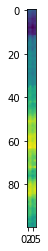

In [12]:
plt.imshow(dataset[0])

In [26]:
dataset[1259]

array([], shape=(0, 4), dtype=float64)

In [24]:
len(dataset)

1158